# Crop Analysis by Environmental Factors

**Overview and Setup:**

This notebook builds a recommendation model for crop selection based on environmental factors. It's part of a larger exercise that I undertook to establish the connection between climate change and hunger in India.

This project leverages data that contains within each record, environmental factors such as temperature and humidity, and a selected crop for those conditions. It's assumed that the crop choice was ideal under the circumstances. Based on that, it builds a recommendation model for crop selection based on environmental factors.

The hypothesis for the larger initiative is that raising temperatures and reducing rainfall will push adoption of a select few crops. Their input profile, such as fertilizer needs (potash for Potassium, urea for Nitrogen), and pesticides needs, will affect their viability as well as nutrition available to the masses.

**Modules Required:**

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

**Verify Dataset**

In [ ]:
url = '/https://drive.google.com/drive/my-drive/Crop_recommendation.csv'
df = pd.read_csv(url)
X = df[['N','P','K','temperature','humidity','ph','rainfall']]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [ ]:
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


**Data Profiling:**

Using seaborn heatmap, we can quickly see that we don't have any null data here.

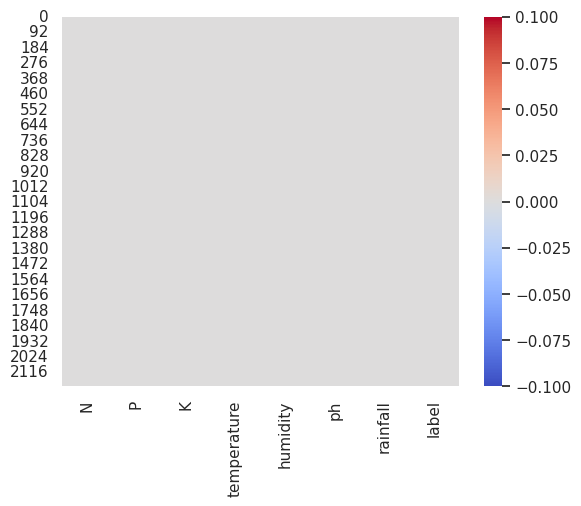

In [ ]:
sns.heatmap(df.isnull(), cmap="coolwarm")
plt.show()



*   Temperature and pH have a normal distribution.
*   Humidity is mostly a bimodal distribution.




<Axes: xlabel='humidity', ylabel='Density'>

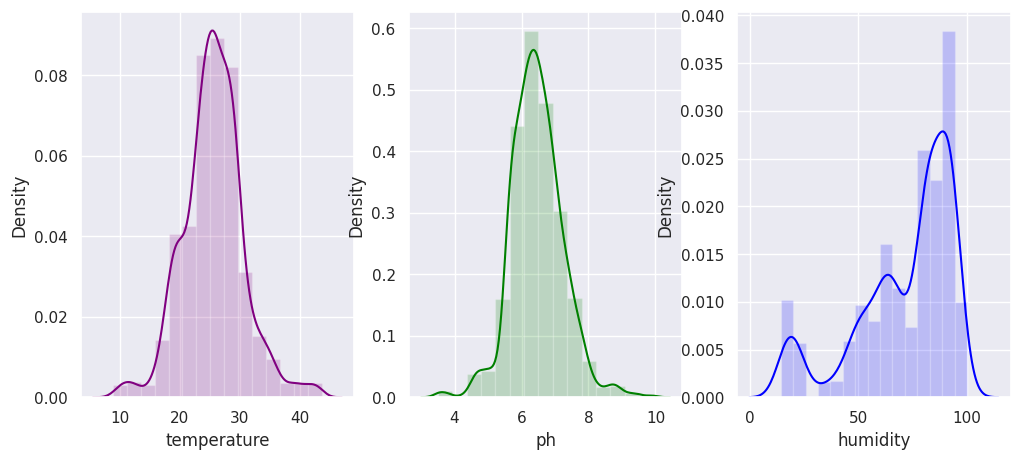

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1, 3, 1)
sns.distplot(df['temperature'],color="purple",bins=15,hist_kws={'alpha':0.2})
plt.subplot(1, 3, 2)
sns.distplot(df['ph'],color="green",bins=15,hist_kws={'alpha':0.2})
plt.subplot(1, 3, 3)
sns.distplot(df['humidity'],color="blue",bins=15,hist_kws={'alpha':0.2})

We have identical number of observations for each crop, which is great.

<Axes: xlabel='count', ylabel='label'>

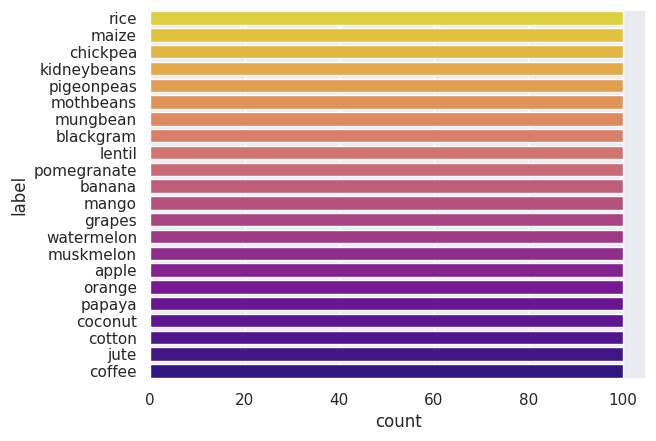

In [ ]:
sns.countplot(y='label',data=df, palette="plasma_r")

High level visualization of features of different crops.

In [ ]:
import plotly.graph_objects as go

df2 = df.copy()

dfg = pd.DataFrame({'label':df2['label'].unique()})
dfg['dummy'] = dfg.index
df2 = pd.merge(df2, dfg, on = 'label', how='left')

dimensions = list([dict(range=[0,df2['dummy'].max()], tickvals = dfg['dummy'], ticktext = dfg['label'], label='Crops', values=df2['dummy']),
                   dict(range=[df2['N'].min(), df2['N'].max()], label='N', values=df2['N']),
                   dict(range=[df2['P'].min(), df2['P'].max()], label='P', values=df2['P']),
                   dict(range=[df2['K'].min(), df2['K'].max()], label='K', values=df2['K']),
                   dict(range=[df2['temperature'].min(), df2['temperature'].max()], label='Temperature', values=df2['temperature']),
                   dict(range=[df2['humidity'].min(), df2['humidity'].max()], label='Humidity', values=df2['humidity']),
                   dict(range=[df2['ph'].min(),df2['ph'].max()], label='pH', values=df2['ph']),
                   dict(range=[df2['rainfall'].min(),df2['rainfall'].max()], label='Rainfall', values=df2['rainfall'])])

fig = go.Figure(data=go.Parcoords(line = dict(color = df2['dummy'], colorscale = 'magma'), dimensions=dimensions))
fig.update_layout(height = 550, width = 1000, title='Crop Feature Distribution', title_font_size=20, title_x=0.5, title_y=0.95)
fig.show()

Using a pairwise plot, visualize the sweet spot for each crop for a pair of features.

When the two chart axes are the same (diagonal charts here), pairplot will by default will show the feature on X-axis and row counts on Y-axis.

If one needs to "zoom" into any one of these feature pairs, they can use sns.jointplot().

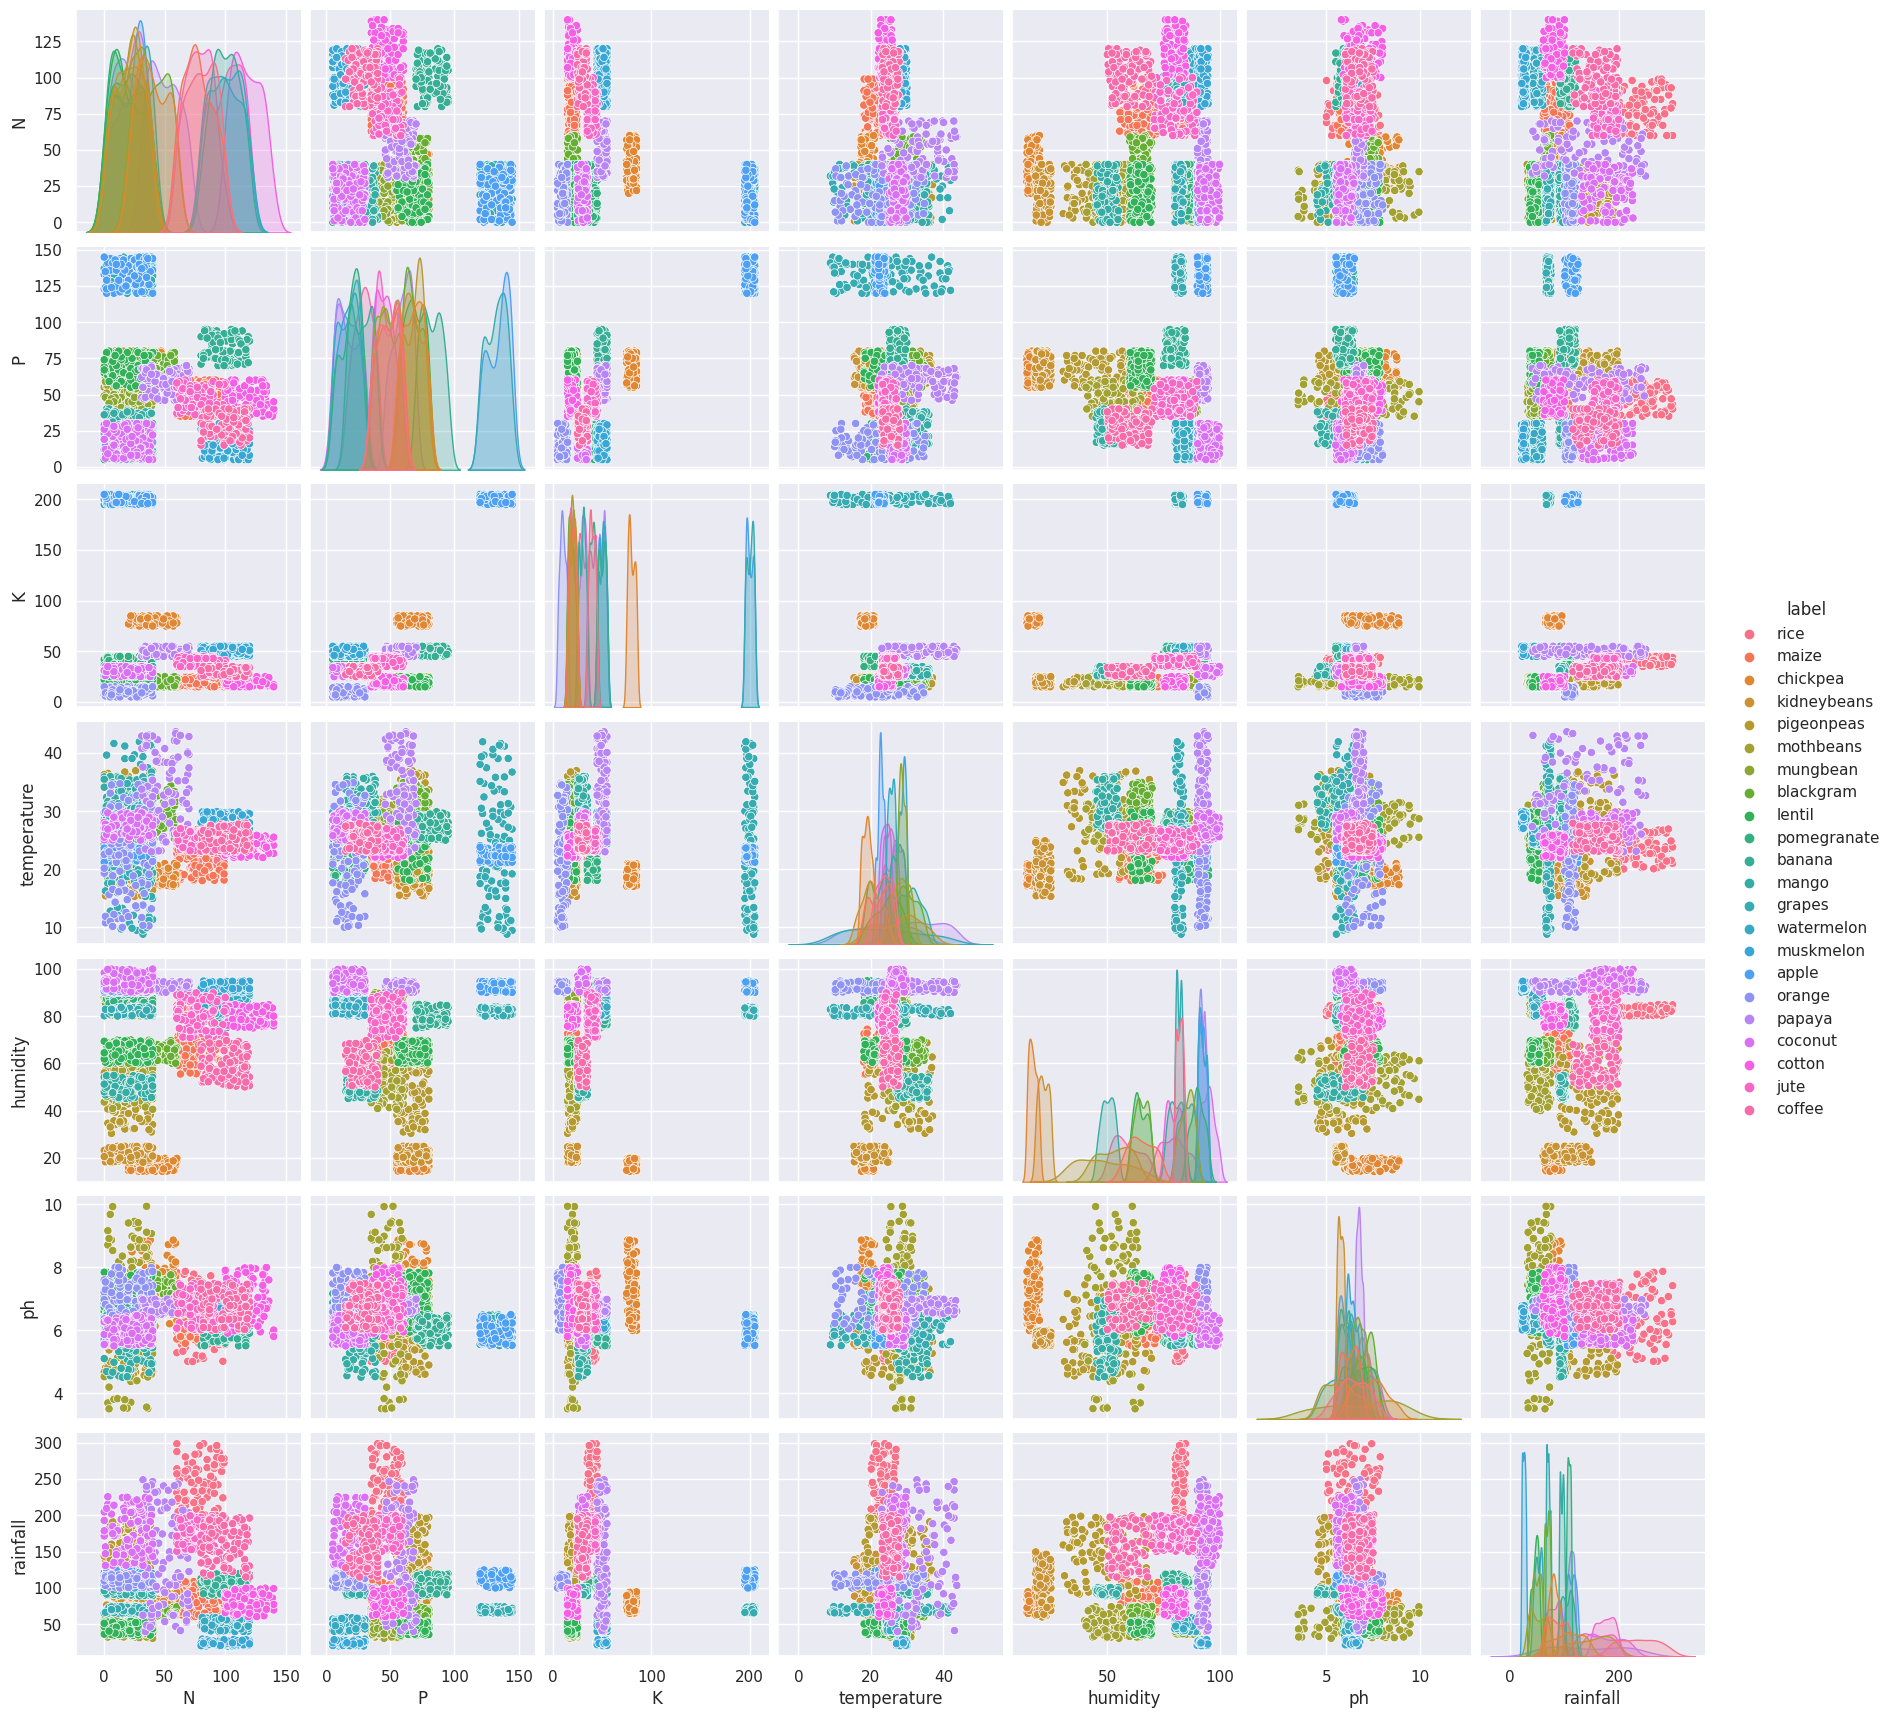

In [ ]:
sns.pairplot(df, hue = 'label')

Visualize the variance of each environmental factor, per crop, using boxplots.

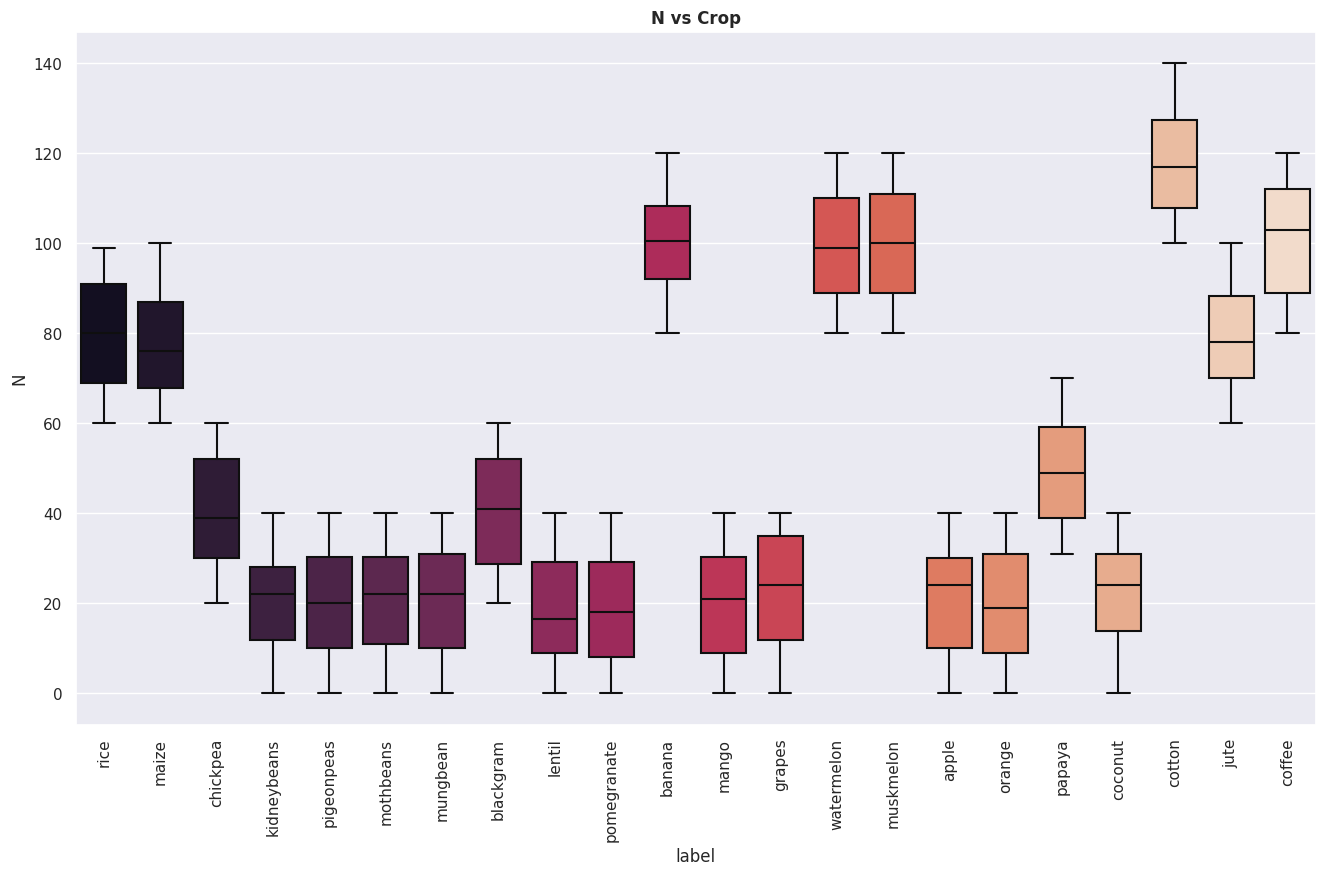

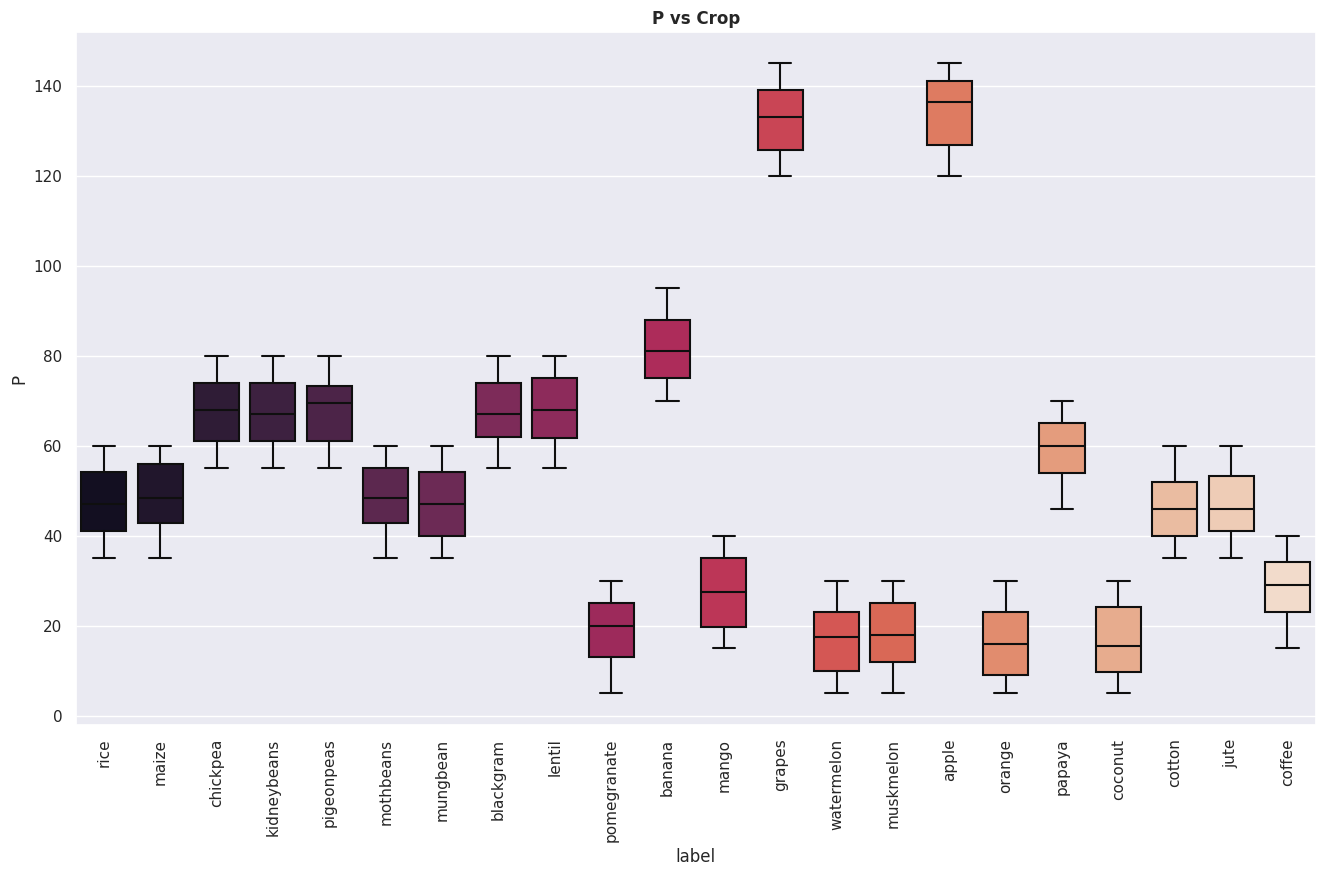

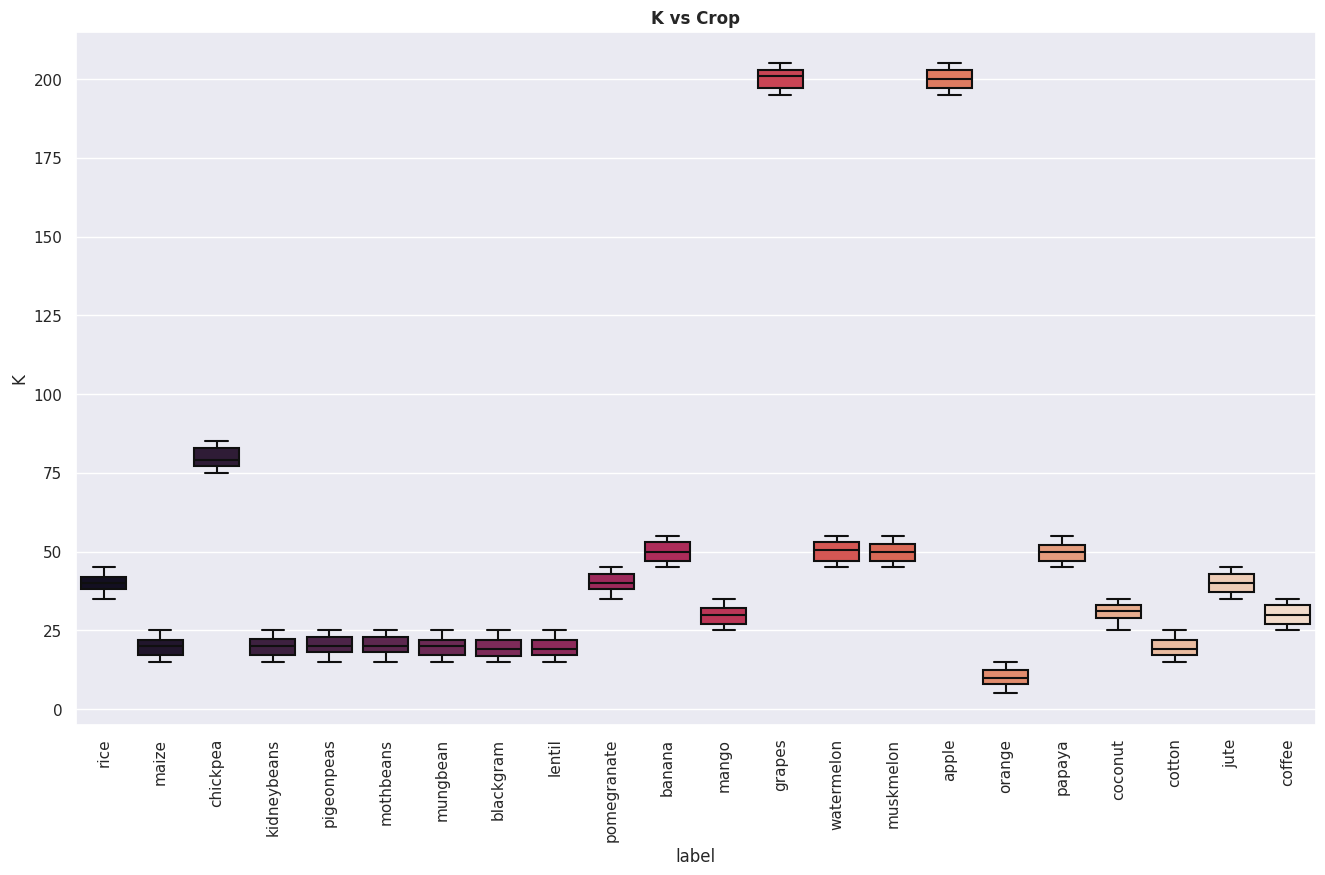

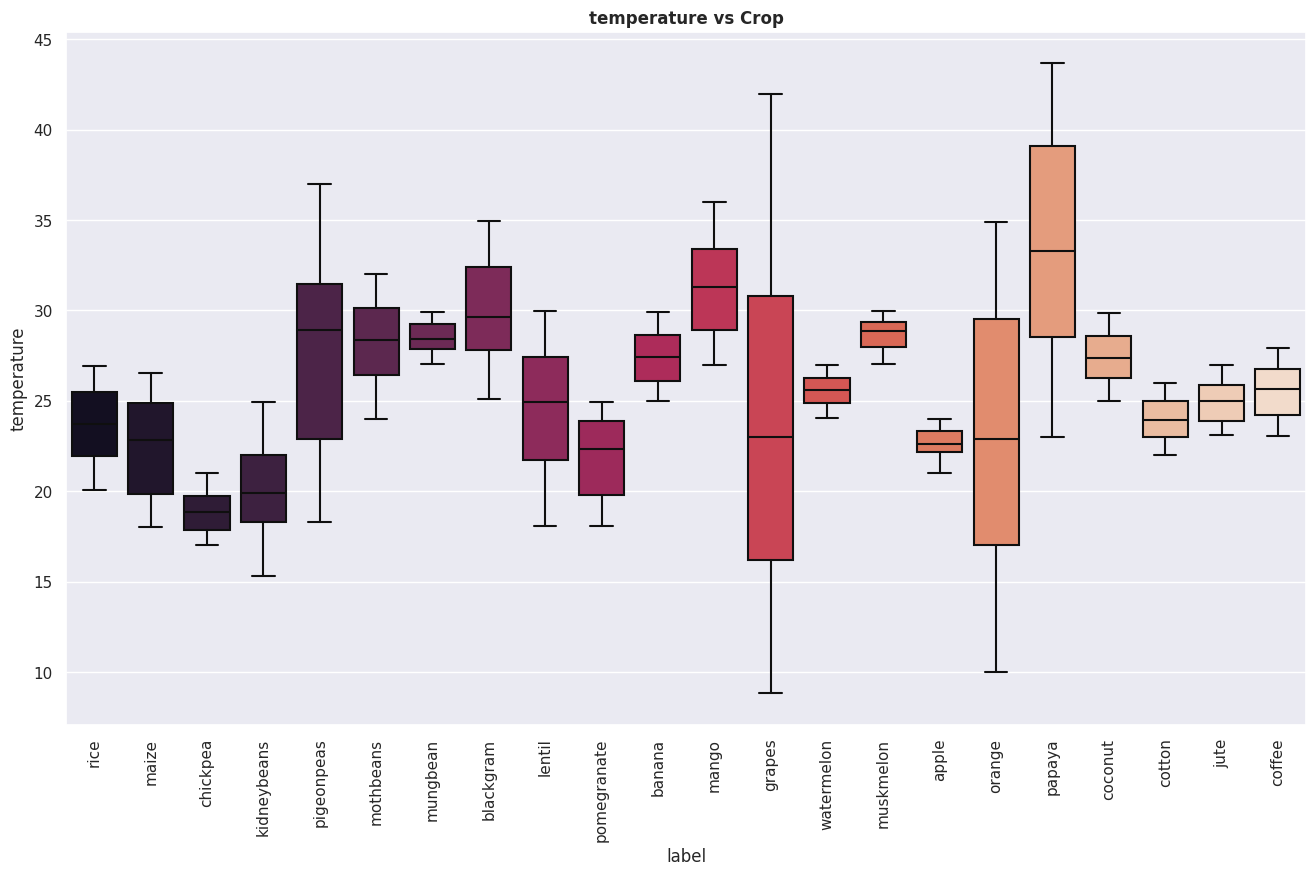

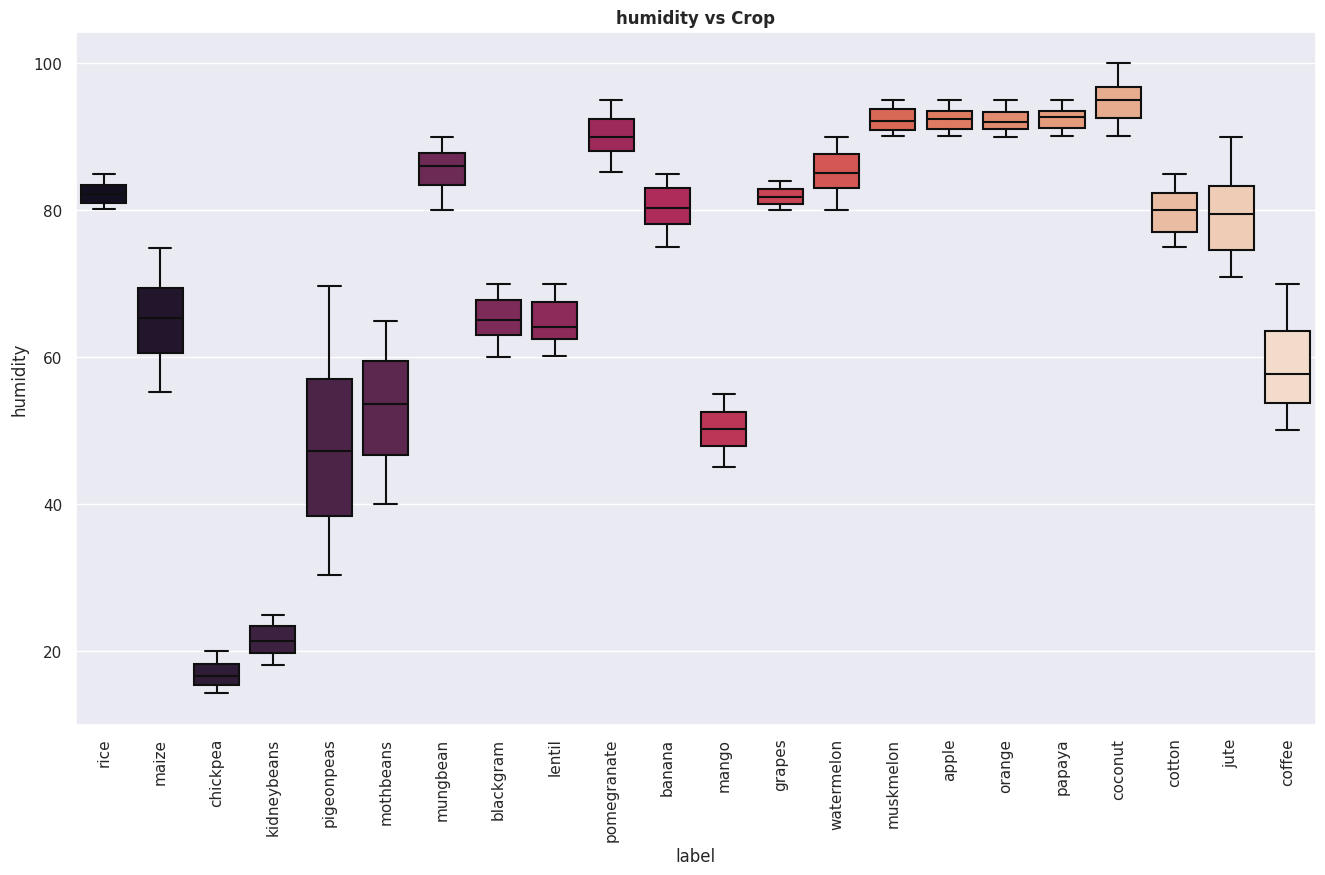

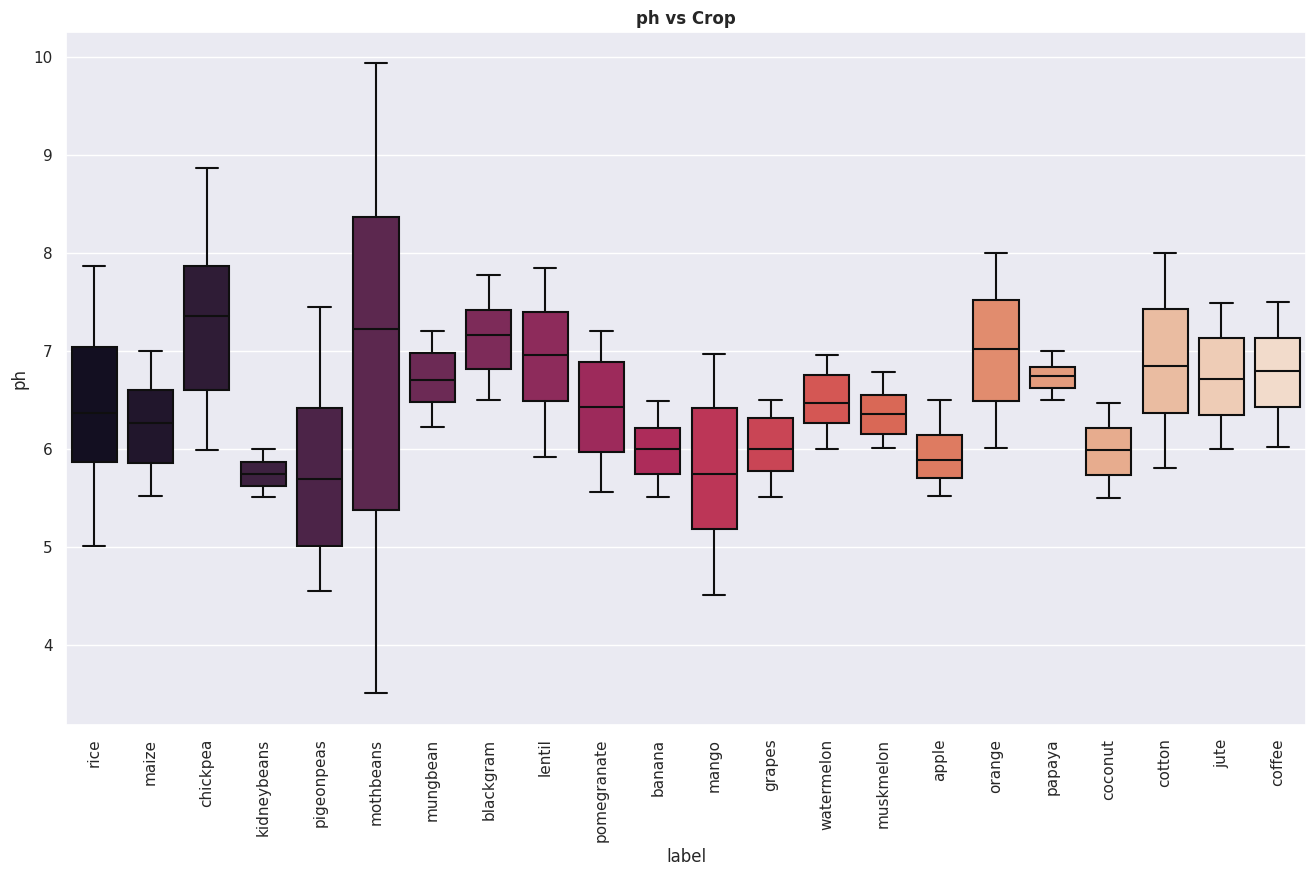

In [ ]:
all_col = df.columns[:-2]

for col in all_col:
  plt.figure(figsize = (16, 9))
  sns.boxplot(x = 'label', y = col, data = df, palette = 'rocket')
  plt.xlabel('label', fontsize = 12)
  plt.ylabel(col, fontsize = 12)
  plt.xticks(rotation=90)
  plt.title(f'{col} vs Crop', fontweight='bold')
  plt.show()

Feature correlations can interfere with training of some types of models because these features do not work independently. Checking for correlation, we see that we only have mild correlation except for Phosphorus and Potassium. Both of these nutrients are necessary for plant maintenance and farmers who use fertilizers, tend to apply both.

<Axes: >

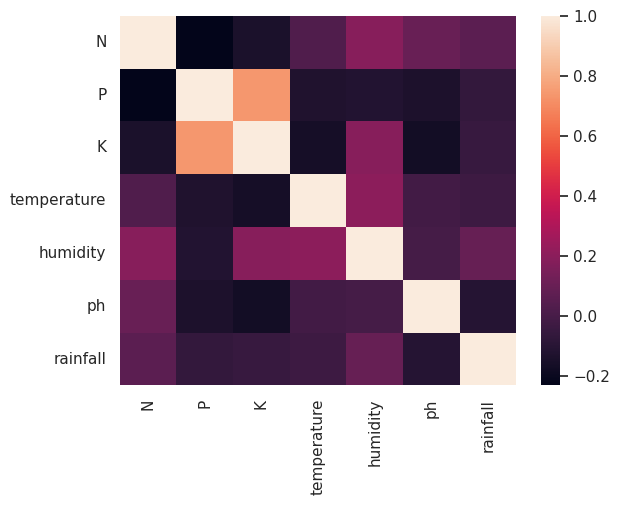

In [ ]:
sns.heatmap(X.corr())

# Data Pre-Processing

In [ ]:
# Map labels to categories and use the category code for Y.

c = df.label.astype('category')
targets = dict(enumerate(c.cat.categories))
df['target'] = c.cat.codes
Y = c.cat.codes

In [ ]:
# Split data into training and test data.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y,random_state=1)

In [ ]:
# Scale training and test data both to be within 0 and 1.
# We are doing this because we are going to use the KNN Classifier
# below which is based on Eucledian distance. Hence, by scaling all
# features, we can be sure that any one feature with large absolute
# measures does not end up dominating the model.

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Utilities**

In [ ]:
def plot_feature_importance(feature_importances):
    """
    Plots feature importance for a variety of models where it's available.
    Note that some models will not have feature importances readily
    available because their kernel might map the input feature space into
    a higher dimensional space for learning, which his disconnected from the
    input features.
    """
    plt.figure(figsize=(10,4), dpi=80)
    c_features = len(X_train.columns)
    plt.barh(range(c_features), feature_importances)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), X_train.columns)
    plt.show()

# Model Selection

**KNN Classifier:**

Accuracy with the default KNN classifier is around 97%, also see the confusion matrix below.

By default, KNN classifier will only use the nearest 5 neighbors and sometimes experimentation is needed to determine if a better count exists, though one must avoid overfitting when looking for the maxima.

<Axes: >

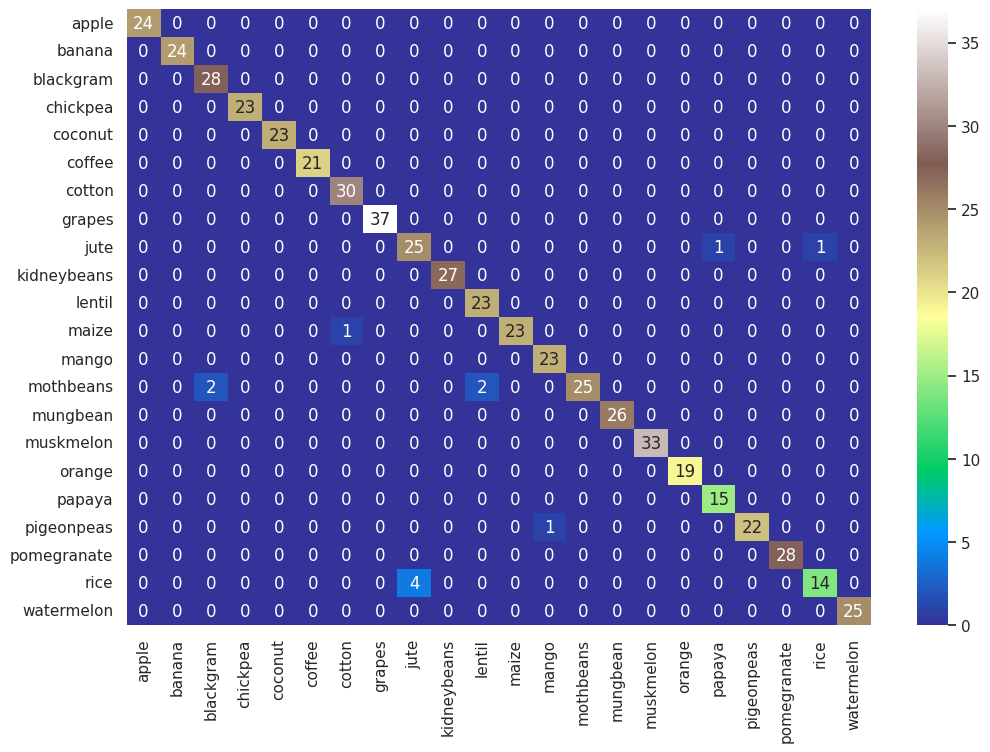

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
knn.score(X_test_scaled, y_test)

from sklearn.metrics import confusion_matrix

predictions = knn.predict(X_test_scaled)
mat = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(mat, list(targets.values()), list(targets.values()))
# Set label size.
sns.set(font_scale=1.0)
plt.figure(figsize = (12,8))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12},cmap="terrain")

Compute accuracy for a range of other NN values. We see that k = 10 gives the best results, which is what we'll use in our final model below.

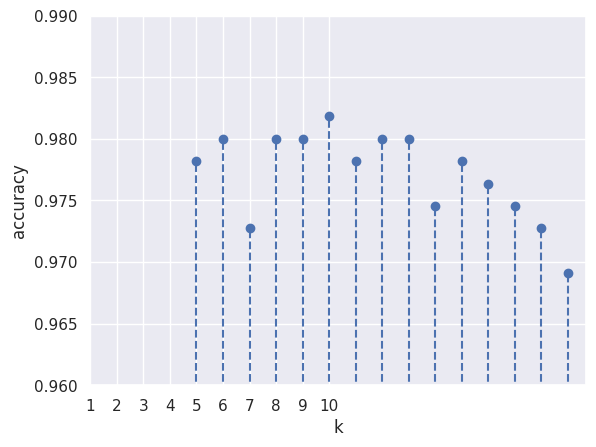

In [ ]:
k_range = range(5, 20)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_scaled, y_train)
    scores.append(knn.score(X_test_scaled, y_test))
    
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.vlines(k_range,0, scores, linestyle="dashed")
plt.ylim(0.96,0.99)
plt.xticks([i for i in range(1,11)]);   

In [ ]:
knn_best = KNeighborsClassifier(n_neighbors=10)
knn_best.fit(X_train_scaled, y_train)
knn_best.score(X_test_scaled, y_test)

0.9818181818181818

**Random Forest:**

To avoid overfitting, we should fine tune max_depth and n_estimators. We find the optimal params for these below by plotting the accuracy for various choices first.

0 -> 3, 50
1 -> 3, 75
2 -> 3, 100
3 -> 3, 125
4 -> 3, 150
5 -> 3, 175
6 -> 3, 200
7 -> 3, 225
8 -> 4, 50
9 -> 4, 75
10 -> 4, 100
11 -> 4, 125
12 -> 4, 150
13 -> 4, 175
14 -> 4, 200
15 -> 4, 225
16 -> 5, 50
17 -> 5, 75
18 -> 5, 100
19 -> 5, 125
20 -> 5, 150
21 -> 5, 175
22 -> 5, 200
23 -> 5, 225


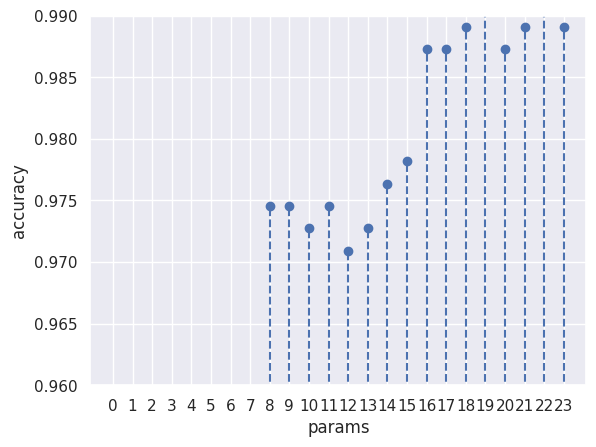

In [ ]:
from sklearn.ensemble import RandomForestClassifier

max_depth_range = range(3, 6)
n_estimators_range = range(50, 250, 25)
scores = []

i = 0
for d in max_depth_range:
    for e in n_estimators_range:
        clf = RandomForestClassifier(max_depth=d, n_estimators=e, random_state=42)
        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))
        print(f'{i} -> {d}, {e}')
        i = i + 1

plt_labels = range(0, len(scores))
plt.xlabel('params')
plt.ylabel('accuracy')
plt.scatter(plt_labels, scores)
plt.vlines(plt_labels, 0, scores, linestyle="dashed")
plt.ylim(0.96,0.99)
plt.xticks([i for i in range(0, len(scores))]);

RF Accuracy on training set: 0.98
RF Accuracy on test set: 0.99


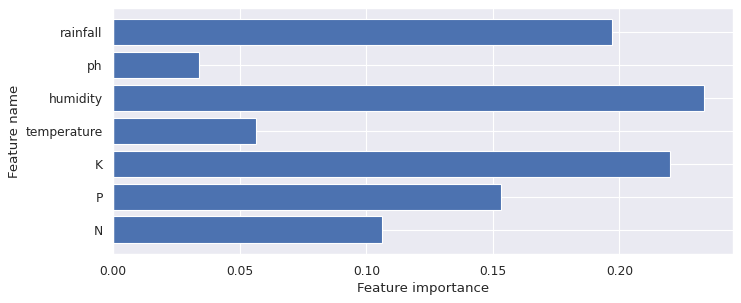

In [ ]:
clf = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=42).fit(X_train, y_train)

print('RF Accuracy on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('RF Accuracy on test set: {:.2f}'.format(clf.score(X_test, y_test)))
plot_feature_importance(clf.feature_importances_)

rf_best = clf